In [814]:
import numpy as np
import random
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from bioinfokit.analys import stats
import sys
import statsmodels.stats.multicomp as s
import math
from pymoo.algorithms.nsga2 import calc_crowding_distance
from pymoo.util.randomized_argsort import randomized_argsort
np.set_printoptions(threshold=np.inf)


In [900]:
nFormigas = 10     # NÃºmero de formigas\n",
erroMin = 1e-04       # Erro minimo - CritÃ©rio de parada\n",
maxIter = 10     # MÃ¡ximo de iteraÃ§Ãµes - CritÃ©rio de parada\n",
nVariaveis = 30       # NÃºmero de variÃ¡veis do problema\n",
nAmostra = 100       # NÃºmero de amostra no espaÃ§o contÃ­nuo\n",
    
# DistribuiÃ§Ã£o Normal\n",
    
q = 0.9
sigma = q * nAmostra
mu = 0.8
xi = 1.0


In [901]:
def dominancia(quantidade_funcoes, lista_funcoes1, lista_funcoes2):
    domina_parcial = 0 
    domina_total = 0
    domina = False
    for i in range(0, quantidade_funcoes):
        if lista_funcoes1[i] <= lista_funcoes2[i]:
            domina_parcial += 1
        if lista_funcoes1[i] < lista_funcoes2[i]:
            domina_total += 1
    if (domina_parcial == quantidade_funcoes) and (domina_total >= 1):
         domina = True
    return domina_parcial, domina_total, domina


In [902]:
def roleta(p):
    sorteio = random.uniform(0, 1)  
    somatorio = 0
    
    for i in range(0,len(p)):
        somatorio += p[i]   
        if(somatorio >= sorteio):
            return i      
         
    return 0


In [948]:
# Multiobjetivo\n",
def inicializacao_zdt1():
    nVariaveis = 30

    limites_lo = [0] * 30
    limites_up = [1] * 30
    zdt2 = get_problem("zdt1")
    return nVariaveis, None, zdt1, limites_up, limites_lo, None

def inicializacao_zdt2():
    nVariaveis = 30

    limites_lo = [0] * 30
    limites_up = [1] * 30
    zdt2 = get_problem("zdt2")
    return nVariaveis, None, zdt2, limites_up, limites_lo, None

def inicializacao_zdt3():
    nVariaveis = 30

    limites_lo = [0] * 30
    limites_up = [1] * 30
    zdt3 = get_problem("zdt3")
    return nVariaveis, None, zdt3, limites_up, limites_lo, None

In [949]:
def zdt1(X, n):
    results = []
    f1 = X[0]  # objective 1
    g = 1 + 9 * np.sum(X[1:n]/ (n-1))
    h = 1 - np.sqrt(f1 / g)
    f2 = g * h  # objective 2
    results.append(f1)
    results.append(f2)
    return results

In [950]:
nVariaveis, restricoes, f_obj, Up, Lo, resultado_otimo = inicializacao_zdt2()


In [951]:
qfuncoesobjetivo = 2
def ACO(nFormigas, maxIter, nVariaveis, restricoes, f_obj, Lo, Up, resultado_otimo):
    
    status = 0 
    solucao = np.zeros((nAmostra, nVariaveis+3))
    resultados = np.zeros((nFormigas, qfuncoesobjetivo))
    
    # Escolhe o mínimo de todas as formigas para salvar a soluÃ§Ã£o\n",
    for amostra in range(0, nAmostra):
        randSolucao = np.zeros((nFormigas, nVariaveis))
        resultados = np.zeros((nFormigas, qfuncoesobjetivo))
        for formiga in range(0, nFormigas):
            for variavel in range(0, nVariaveis):
                randSolucao[formiga, variavel] = (Up[variavel] - Lo[variavel])  * random.random() + Lo[variavel]#FunÃ§Ã£o Uniforme\n",            
            resultados[formiga]  = f_obj.evaluate(randSolucao[formiga, :], nVariaveis)

        dominancias = []
        for fitness in resultados:
            contagem = 0
            for fitness1 in resultados:
                if dominancia(qfuncoesobjetivo, fitness1, fitness)[2]:
                    contagem+=1
            dominancias.append(contagem)
        
        indexFormiga = np.where(dominancias == np.min(dominancias))[0]        
        variaveisMelhorFormiga = randSolucao[indexFormiga, :][0]
        variaveisMelhorFormiga = np.append(variaveisMelhorFormiga, dominancias[indexFormiga[0]])
        variaveisMelhorFormiga = np.append(variaveisMelhorFormiga, resultados[indexFormiga[0]])
        solucao[amostra,:] = variaveisMelhorFormiga        
    # Ordena a tabela de arquivos do melhor para o pior\n",
    solucao = solucao[solucao[:,nVariaveis].argsort()]
    
    #print(solucao[:, nVariaveis+1])
    ##print(solucao[:, nVariaveis+2])
    #print(solucao[:, 0:nVariaveis])
    #return solucao        
    
    quantidade_selecao = int(nAmostra/5)
    
    
    w = np.zeros(nAmostra)

    # Cria peso para cada amostra\n",
    for amostra in range(0, nAmostra):
        w[amostra] = norm.pdf(amostra, mu, sigma)
        
    p = w/np.sum(w)
    #plt.plot(p)
    #plt.show()
 
    for iteracao in range(0, maxIter):
        # cÃ¡lculo da probabilidade de escolher baseado no feromÃ´nio\n",

        #if (status == 2) or (status == 3):  # NÃ£o continuar, nova soluÃ§Ã£o\n",      
        #p_selecionada = roleta(p)     
        #print(p_selecionada)
        p = np.random.randint(low=0, high=20, size=(1,))
       
        nova_solucao = solucao[p[0]] 
        #elif status == 1: # continuar com a soluÃ§Ã£o\n",
        
        delta_soma = np.zeros(nVariaveis)
        delta = np.zeros(nVariaveis)

        # CÃ¡lculo do desvio padrÃ£o\n",
        for variavel in range(0, nVariaveis):
            for amostra in range(0, nAmostra):
                delta_soma[variavel] = delta_soma[variavel] + abs(solucao[amostra, variavel] - nova_solucao[variavel])
            delta[variavel] = (xi * delta_soma[variavel]) /(nAmostra - 1)            
        
        k = []
        # Pertubar os valores da nova_solucao\n",
        
        for formiga in range(0,nFormigas):
            k = []
            for variavel in range(0, nVariaveis):
                rand = np.random.randn()                
                gene = delta[variavel] * rand + nova_solucao[variavel]
                
                if gene > Lo[0]:
                    gene = Lo[0]
                if gene < Up[0]:
                    gene = Up[0]   
                k.append(gene)
          
            k = np.array(k)
            resultado = f_obj.evaluate(k, nVariaveis)
            k = np.append(k, 0)
            k = np.append(k,resultado[0])
            k = np.append(k,resultado[1])
            solucao = np.append(solucao, [k], axis=0)  
        
        fitness = []  # Recalcula objetivos
        
        for s in solucao:
            fitness.append(f_obj.evaluate(s[0:nVariaveis], nVariaveis))
        
        for i in range(0, len(fitness)):
            contagem = 0
            for j in range(0, len(fitness)):
                if dominancia(qfuncoesobjetivo, fitness[j], fitness[i])[2]:
                    contagem+=1
            solucao[i][nVariaveis] = contagem
            solucao[i][nVariaveis+1] = fitness[i][0]
            solucao[i][nVariaveis+2] = fitness[i][1]
            
        solucao = solucao[solucao[:,nVariaveis].argsort()]
      
        solucao = solucao[0:nAmostra]
        f = 0
        fronts = []
        crowding_distances = []
        ordenado_crowding = []
        
        for s in solucao:
            if f != s[nVariaveis]:
                f = s[nVariaveis]
                    
                nfronts = np.array(fronts)
                c = calc_crowding_distance(nfronts[:,[nVariaveis+1,nVariaveis+2 ]]) 

                ordenado = randomized_argsort(c, order='descending', method='numpy')

                for index in ordenado:
                    ordenado_crowding.append(fronts[index])
                fronts = []
            fronts.append(s)
        ordenado_crowding.extend(fronts)
        solucao = np.array(ordenado_crowding[0:nAmostra])
        
        
        
        #print(solucao)
   
    return solucao


In [952]:
nFormigas = 500
maxIter = 50
s = ACO(nFormigas, maxIter, nVariaveis, restricoes, f_obj, Up, Lo, resultado_otimo)

In [933]:
print(s)

[[ 6.23281933e-01  1.93339569e-03  4.91839156e-03  1.87270180e-03
   2.90378724e-04  9.10585143e-04  3.21046309e-04  1.21787801e-03
   6.61063175e-04  3.40935115e-03  0.00000000e+00  1.37404583e-04
   6.82583368e-03  2.23588574e-04  4.44849394e-03  1.15534396e-02
   4.32831935e-04  5.77318894e-03  0.00000000e+00  4.31900078e-04
   2.46086368e-03  1.22040522e-02  2.37150594e-03  0.00000000e+00
   0.00000000e+00  1.16088259e-03  2.19117350e-03  1.61806319e-03
   1.44146847e-03  0.00000000e+00  0.00000000e+00  6.23281933e-01
  -1.92820962e-01]
 [ 2.50233881e-01  0.00000000e+00  1.21742133e-02  0.00000000e+00
   3.08094354e-03  2.83788221e-04  9.92681047e-04  1.27066386e-03
   1.02659139e-04  9.24650810e-03  9.04145039e-05  0.00000000e+00
   1.10417810e-02  1.67254542e-05  1.08686489e-02  0.00000000e+00
   8.90265235e-04  5.83228152e-03  8.65693508e-05  1.02253327e-03
   0.00000000e+00  0.00000000e+00  7.98866279e-04  4.15160605e-04
   2.52773507e-04  0.00000000e+00  0.00000000e+00  2.0808

In [955]:
nFormigas = 400
maxIter = 50
nVariaveis = 30
ref = [11, 11]
hypervolumes = []
hypervolumes_1 = []

problem = get_problem("zdt2")
algorithm = NSGA2(pop_size=100)
for i in range(0,30):
    s = ACO(nFormigas, maxIter, nVariaveis, restricoes, f_obj, Up, Lo, resultado_otimo)
    nao_dominados = s[s[:,nVariaveis] == 0]
    hv = hypervolume(nao_dominados[:,[nVariaveis+1,nVariaveis+2 ]])
    r = hv.compute(ref)
    print(r)
    hypervolumes.append(r)
    res = minimize(problem, algorithm, ('n_gen', 200),seed=1,verbose=False)
    hv = hypervolume(res.F)
    r1 = hv.compute(ref)
    print(r1)
    hypervolumes_1.append(r1)

109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520753678
120.27503079165919
109.99999520

[[0.68586257 0.53594698]
 [0.58650332 0.66270109]
 [0.71442454 0.49599239]
 [0.69927948 0.51772276]
 [0.65701676 0.57348324]
 [0.77311004 0.40908304]
 [0.55646297 0.69688292]
 [0.98477202 0.0420883 ]
 [0.23149612 0.94874936]
 [0.88336216 0.23180452]
 [0.53721211 0.71837844]
 [0.66310712 0.56893851]
 [0.96247283 0.0818933 ]
 [1.         0.00364565]
 [0.14312247 0.98321527]
 [0.72203041 0.4848292 ]
 [0.63506033 0.59970087]
 [0.7476053  0.45081215]
 [0.666664   0.55783479]
 [0.14607928 0.98223625]
 [0.41597404 0.83084574]
 [0.58939187 0.65771544]
 [0.62357403 0.61611315]
 [0.85990185 0.26903345]
 [0.47185851 0.78288729]
 [0.85131675 0.28290652]
 [0.7506877  0.44164704]
 [0.7705502  0.41477369]
 [0.43904003 0.81147973]
 [0.72171037 0.48672955]
 [0.5599042  0.69282039]
 [0.79263265 0.38047708]
 [0.46107565 0.79178502]
 [0.59727811 0.64791548]
 [0.58748254 0.65981153]
 [0.74306042 0.45174563]
 [0.8119429  0.35046813]
 [0.48305679 0.76996547]
 [0.5279394  0.7238838 ]
 [0.70777386 0.50699944]


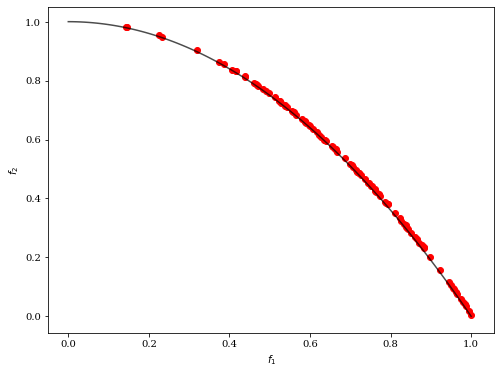

In [954]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt2")
algorithm = NSGA2(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 200),seed=1,verbose=False)
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
nao_dominados = s[s[:,nVariaveis] == 0]
plot.add(nao_dominados[:,[nVariaveis+1,nVariaveis+2 ]], color="red")

print(nao_dominados[:,[nVariaveis+1,nVariaveis+2 ]])
plot.show()

In [956]:
from scipy import stats
hypervolumes = [127.51355456590836] * 30
stats.ttest_ind(hypervolumes,hypervolumes_1)

Ttest_indResult(statistic=760776569153660.1, pvalue=0.0)